In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict, ClassLabel

pd_tweets = pd.read_csv('data/tweets-refined.csv')

In [2]:
pd_tweets

,slang/informal,text
0,no,"@VirginAmerica it was amazing, and arrived an ..."
1,no,@VirginAmerica did you know that suicide is th...
2,no,@VirginAmerica This is such a great deal! Alre...
3,yes,@VirginAmerica @virginmedia I'm flying your #f...
4,no,@VirginAmerica Thanks!
...,...,...
297,yes,"@united Thx, just DM'd. Conf #'s MQXC64 &amp; ..."
298,yes,@united pls stop sending texts every 15mins sa...
299,yes,@united pls follow for DM
300,yes,@united. Pls hold UA2066 for 9 cnx pax frm UA...


In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(pd_tweets, test_size=0.3, random_state=1)

In [4]:
validation_df, test_df = train_test_split(test_df, test_size = 0.5, random_state=1)

In [5]:
train_tweets = Dataset.from_pandas(train_df, split="train")
test_tweets = Dataset.from_pandas(test_df, split="test")
val_tweets = Dataset.from_pandas(validation_df, split="validation")

In [6]:
train_tweets = train_tweets.class_encode_column('slang/informal')
test_tweets = test_tweets.class_encode_column('slang/informal')
val_tweets = val_tweets.class_encode_column('slang/informal')

Casting to class labels:   0%|          | 0/211 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/46 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/45 [00:00<?, ? examples/s]

In [7]:
train_tweets = train_tweets.rename_column("slang/informal", "label")
test_tweets = test_tweets.rename_column("slang/informal", "label")
val_tweets = val_tweets.rename_column("slang/informal", "label")

In [8]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def preprocess(sample):
    
    return tokenizer(sample["text"], truncation=True)

In [9]:
tweets_dict = {"train": train_tweets, "test": test_tweets, "validation": val_tweets}
tweets_dict

{'train': Dataset({
     features: ['label', 'text', '__index_level_0__'],
     num_rows: 211
 }),
 'test': Dataset({
     features: ['label', 'text', '__index_level_0__'],
     num_rows: 46
 }),
 'validation': Dataset({
     features: ['label', 'text', '__index_level_0__'],
     num_rows: 45
 })}

In [10]:
tweets_ds_dict = DatasetDict(tweets_dict)
tweets_ds_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 211
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 46
    })
    validation: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 45
    })
})

In [11]:
tokenized_tweets = tweets_ds_dict.map(preprocess, batched=True)

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [12]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2024-05-02 22:55:18.201530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 22:55:19.434532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
import evaluate

metric = evaluate.load("accuracy")

In [14]:
import numpy as np

def compute_metrics(preds):
    logits, labels = preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(references=labels, predictions=predictions)

In [21]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

batch_size = 16 # can experiment with different sizes

args = TrainingArguments(
    f"distilbert-finetuned-tweets", # directory to save the model
    evaluation_strategy = "epoch", # evaluate after each epoch
    save_strategy = "epoch", # save after each epoch
    learning_rate=2e-5, # the learning rate to use
    per_device_train_batch_size=batch_size, # the batch size
    per_device_eval_batch_size=batch_size,
    logging_steps=100,
    num_train_epochs=10, # number of epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model = 'accuracy'
)

In [22]:
# autoload a model from the base for sequence classification,
# we pass 2 labels since this is binary classification.
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,  # the pre-trained model
    args,  # the TrainingAgruments, defined above
    train_dataset=tokenized_tweets["train"], # the training dataset
    eval_dataset=tokenized_tweets["validation"], # the validation dataset
    tokenizer=tokenizer, # our tokenizer
    data_collator=data_collator, # the collator we defined above
    compute_metrics=compute_metrics # our function for computing the metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.651506,0.577778
2,No log,0.551575,0.777778
3,No log,0.419003,0.866667
4,No log,0.364709,0.866667
5,No log,0.354859,0.888889
6,No log,0.393136,0.866667
7,No log,0.454711,0.844444
8,0.339600,0.435851,0.844444
9,0.339600,0.465159,0.844444
10,0.339600,0.476565,0.844444


Checkpoint destination directory distilbert-finetuned-tweets/checkpoint-14 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned-tweets/checkpoint-28 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned-tweets/checkpoint-42 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned-tweets/checkpoint-56 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned-tweets/checkpoint-70 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-finetuned-tweets/checkpoint-84 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination direc

TrainOutput(global_step=140, training_loss=0.2555610869612013, metrics={'train_runtime': 177.5054, 'train_samples_per_second': 11.887, 'train_steps_per_second': 0.789, 'total_flos': 24876704781588.0, 'train_loss': 0.2555610869612013, 'epoch': 10.0})

In [24]:
predictions = trainer.predict(tokenized_tweets["test"])

In [25]:
# chatGPT
predicted_labels = predictions.predictions.argmax(axis=1)

In [26]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0])

In [27]:
actual_labels = tokenized_tweets["test"]['label']

In [28]:
type(actual_labels)

list

In [29]:
predicted_labels = predicted_labels.tolist()

In [30]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(actual_labels, predicted_labels)

<Axes: >

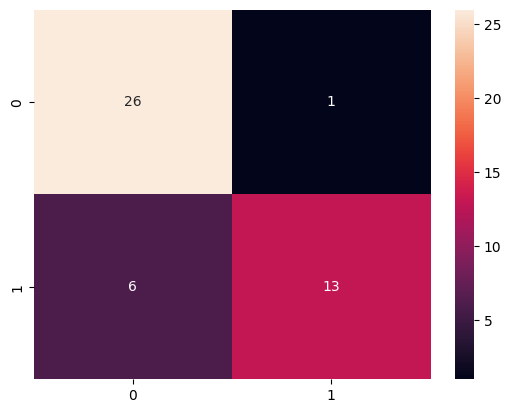

In [31]:
import seaborn as sns
sns.heatmap(confusion_mat, annot=True)

<Axes: >

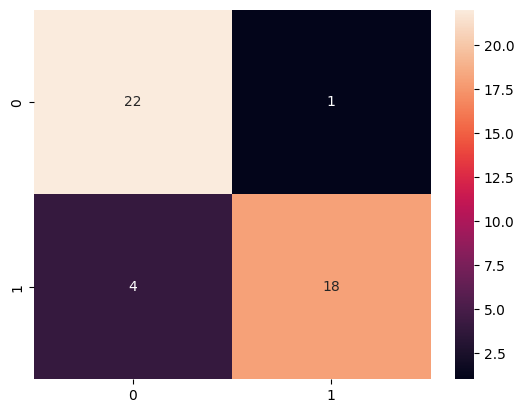

In [32]:
predictions = trainer.predict(tokenized_tweets["validation"])
predicted_labels = predictions.predictions.argmax(axis=1)
predicted_labels = predicted_labels.tolist()
actual_labels = tokenized_tweets["validation"]['label']
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(actual_labels, predicted_labels)
import seaborn as sns
sns.heatmap(confusion_mat, annot=True)